# LionBase x MedX (05/18/2020)
**Objective:** To develop a linear regression model that can accurately predict the death rate from cancer in a given U.S. county, thus allowing for optimal distribution of the new cancer-treating drug developed by MedX. Here, the variable we are trying to predict is labeled "TARGET_deathRate"

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = pd.read_csv('cancer_data.csv', encoding = 'latin-1', index_col = 'Geography')

# Step 1: Cleaning Data

In [3]:
# Checking for null values:
df.isnull().sum()

avgAnnCount                   0
avgDeathsPerYear              0
TARGET_deathRate              0
incidenceRate                 0
medIncome                     0
popEst2015                    0
povertyPercent                0
studyPerCap                   0
binnedInc                     0
MedianAge                     0
MedianAgeMale                 0
MedianAgeFemale               0
AvgHouseholdSize              0
PercentMarried                0
PctNoHS18_24                  0
PctHS18_24                    0
PctSomeCol18_24            2285
PctBachDeg18_24               0
PctHS25_Over                  0
PctBachDeg25_Over             0
PctEmployed16_Over          152
PctUnemployed16_Over          0
PctPrivateCoverage            0
PctPrivateCoverageAlone     609
PctEmpPrivCoverage            0
PctPublicCoverage             0
PctPublicCoverageAlone        0
PctWhite                      0
PctBlack                      0
PctAsian                      0
PctOtherRace                  0
PctMarri

In [4]:
# Let's separate out the columns that contain null values
df_null = df[['PctSomeCol18_24', 'PctEmployed16_Over', 'PctPrivateCoverageAlone']]
df_null.describe()

PctSomeCol18_24  PctEmployed16_Over  PctPrivateCoverageAlone
count       762.000000         2895.000000              2438.000000
mean         40.977034           54.152642                48.453774
std          11.115805            8.315064                10.083006
min           7.100000           17.600000                15.700000
25%          34.000000           48.600000                41.000000
50%          40.400000           54.500000                48.700000
75%          46.400000           60.300000                55.600000
max          79.000000           80.100000                78.900000

In [5]:
# For 'PctEmployed16_Over' and 'PctPrivateCoverageAlone', we are only missing a small percentage of the data, 
# so we can still use these columns as predictors in our regression model. However, 75% of the data for 
# 'PctSomeCol18_24' is missing, so we cannot use this column in our regression model. Our new df is as follows:

df = df.loc[:, df.columns != 'PctSomeCol18_24']
df['PctEmployed16_Over'].fillna(df['PctEmployed16_Over'].mean(), inplace = True)    
df['PctPrivateCoverageAlone'].fillna(df['PctPrivateCoverageAlone'].mean(), inplace = True)   

In [6]:
# Checking for outliers:
df.describe()

avgAnnCount  avgDeathsPerYear  TARGET_deathRate  incidenceRate  \
count   3047.000000       3047.000000       3047.000000    3047.000000   
mean     606.338544        185.965868        178.664063     448.268586   
std     1416.356223        504.134286         27.751511      54.560733   
min        6.000000          3.000000         59.700000     201.300000   
25%       76.000000         28.000000        161.200000     420.300000   
50%      171.000000         61.000000        178.100000     453.549422   
75%      518.000000        149.000000        195.200000     480.850000   
max    38150.000000      14010.000000        362.800000    1206.900000   

           medIncome    popEst2015  povertyPercent  studyPerCap    MedianAge  \
count    3047.000000  3.047000e+03     3047.000000  3047.000000  3047.000000   
mean    47063.281917  1.026374e+05       16.878175   155.399415    45.272333   
std     12040.090836  3.290592e+05        6.409087   529.628366    45.304480   
min     22640.000000  8.270000e+02        3.200000     0.000000    22.300000   
25%     38882.500000  1.168400e+04       12.150000     0.000000    37.700000   
50%     45207.000000  2.664300e+04       15.900000     0.000000    41.000000   
75%     52492.000000  6.867100e+04       20.400000    83.650776    44.000000   
max    125635.000000  1.017029e+07       47.400000  9762.308998   624.000000   

       MedianAgeMale  ...  PctPrivateCoverageAlone  PctEmpPrivCoverage  \
count    3047.000000  ...              3047.000000         3047.000000   
mean       39.570725  ...                48.453774           41.196324   
std         5.226017  ...                 9.018885            9.447687   
min        22.400000  ...                15.700000           13.500000   
25%        36.350000  ...                43.100000           34.500000   
50%        39.600000  ...                48.453774           41.100000   
75%        42.500000  ...                53.800000           47.700000   
max        64.700000  ...                78.900000           70.700000   

       PctPublicCoverage  PctPublicCoverageAlone     PctWhite     PctBlack  \
count        3047.000000             3047.000000  3047.000000  3047.000000   
mean           36.252642               19.240072    83.645286     9.107978   
std             7.841741                6.113041    16.380025    14.534538   
min            11.200000                2.600000    10.199155     0.000000   
25%            30.900000               14.850000    77.296180     0.620675   
50%            36.300000               18.800000    90.059774     2.247576   
75%            41.550000               23.100000    95.451693    10.509732   
max            65.100000               46.600000   100.000000    85.947799   

          PctAsian  PctOtherRace  PctMarriedHouseholds    BirthRate  
count  3047.000000   3047.000000           3047.000000  3047.000000  
mean      1.253965      1.983523             51.243872     5.640306  
std       2.610276      3.517710              6.572814     1.985816  
min       0.000000      0.000000             22.992490     0.000000  
25%       0.254199      0.295172             47.763063     4.521419  
50%       0.549812      0.826185             51.669941     5.381478  
75%       1.221037      2.177960             55.395132     6.493677  
max      42.619425     41.930251             78.075397    21.326165  

[8 rows x 31 columns]

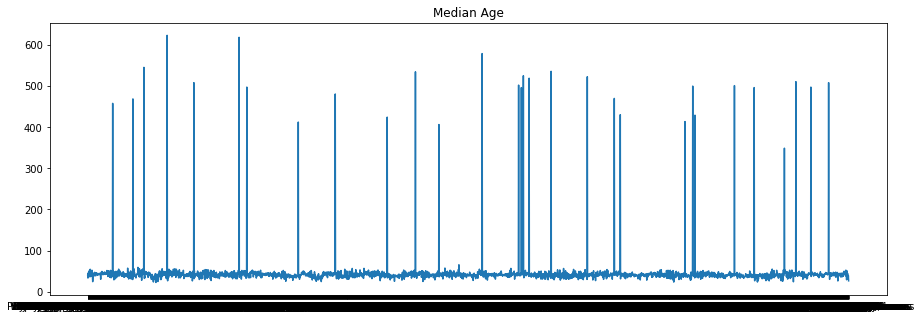

In [7]:
# The maximum for Median Age is impossibly high (624 years old), so we want to investigate:
plt.figure(figsize = (15, 5)) # set x and y lengths
plt.title('Median Age')
plt.plot(df["MedianAge"])

In [8]:
# We see from the plot that there are many outliers for median age that we wish to drop:
df = df.drop(df[df['MedianAge'] > 150].index)
df.describe()

avgAnnCount  avgDeathsPerYear  TARGET_deathRate  incidenceRate  \
count   3017.000000       3017.000000       3017.000000    3017.000000   
mean     607.573376        186.285714        178.648194     448.154402   
std     1422.111040        506.346011         27.737080      54.608081   
min        6.000000          3.000000         59.700000     201.300000   
25%       76.000000         28.000000        161.300000     420.300000   
50%      170.000000         61.000000        178.100000     453.549422   
75%      515.000000        147.000000        195.200000     480.800000   
max    38150.000000      14010.000000        362.800000    1206.900000   

           medIncome    popEst2015  povertyPercent  studyPerCap    MedianAge  \
count    3017.000000  3.017000e+03      3017.00000  3017.000000  3017.000000   
mean    47060.539277  1.027189e+05        16.88240   156.586892    40.823865   
std     12053.191812  3.302862e+05         6.41602   532.071270     5.196933   
min     22640.000000  8.270000e+02         3.20000     0.000000    22.300000   
25%     38887.000000  1.170300e+04        12.20000     0.000000    37.700000   
50%     45207.000000  2.658900e+04        15.80000     0.000000    40.900000   
75%     52476.000000  6.850200e+04        20.40000    83.896902    43.800000   
max    125635.000000  1.017029e+07        47.40000  9762.308998    65.300000   

       MedianAgeMale  ...  PctPrivateCoverageAlone  PctEmpPrivCoverage  \
count    3017.000000  ...              3017.000000         3017.000000   
mean       39.568445  ...                48.452095           41.204972   
std         5.225173  ...                 9.007376            9.426938   
min        22.400000  ...                15.700000           13.500000   
25%        36.400000  ...                43.100000           34.500000   
50%        39.500000  ...                48.453774           41.100000   
75%        42.600000  ...                53.800000           47.600000   
max        64.700000  ...                78.900000           70.700000   

       PctPublicCoverage  PctPublicCoverageAlone     PctWhite     PctBlack  \
count        3017.000000             3017.000000  3017.000000  3017.000000   
mean           36.257474               19.243818    83.673433     9.093275   
std             7.843518                6.116668    16.356226    14.550428   
min            11.200000                2.600000    10.199155     0.000000   
25%            30.900000               14.800000    77.399902     0.620104   
50%            36.400000               18.800000    90.059774     2.238336   
75%            41.600000               23.100000    95.443269    10.420061   
max            65.100000               46.600000   100.000000    85.947799   

          PctAsian  PctOtherRace  PctMarriedHouseholds    BirthRate  
count  3017.000000   3017.000000           3017.000000  3017.000000  
mean      1.255703      1.982160             51.249931     5.639141  
std       2.615716      3.524972              6.580059     1.983919  
min       0.000000      0.000000             22.992490     0.000000  
25%       0.254509      0.294923             47.779088     4.524920  
50%       0.550631      0.826185             51.678241     5.380501  
75%       1.220816      2.176268             55.396115     6.491885  
max      42.619425     41.930251             78.075397    21.326165  

[8 rows x 31 columns]

In [9]:
# Checking for dupliate counties:
len(df[df.duplicated()])

0

In [10]:
# Notice that there are two columns that communicate essentially the same information ('medIncome' shows the 
# median income of a county and 'binnedInc' also shows the median income per capita, just binned by decile)
df[['medIncome', 'binnedInc']]

medIncome           binnedInc
Geography                                                  
Kitsap County, Washington         61898   (61494.5, 125635]
Kittitas County, Washington       48127  (48021.6, 51046.4]
Klickitat County, Washington      49348  (48021.6, 51046.4]
Lewis County, Washington          44243    (42724.4, 45201]
Lincoln County, Washington        49955  (48021.6, 51046.4]
...                                 ...                 ...
Ellsworth County, Kansas          46961    (45201, 48021.6]
Finney County, Kansas             48609  (48021.6, 51046.4]
Ford County, Kansas               51144  (51046.4, 54545.6]
Franklin County, Kansas           50745  (48021.6, 51046.4]
Geary County, Kansas              41193  (40362.7, 42724.4]

[3017 rows x 2 columns]

In [11]:
# The binned data prevents us from moving forward with modeling, and since we have another column that 
# provides essentially the same data, we can go ahead and delete 'binnedInc':
df = df.loc[:, df.columns != 'binnedInc']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1be5b450>,
      dtype=object)

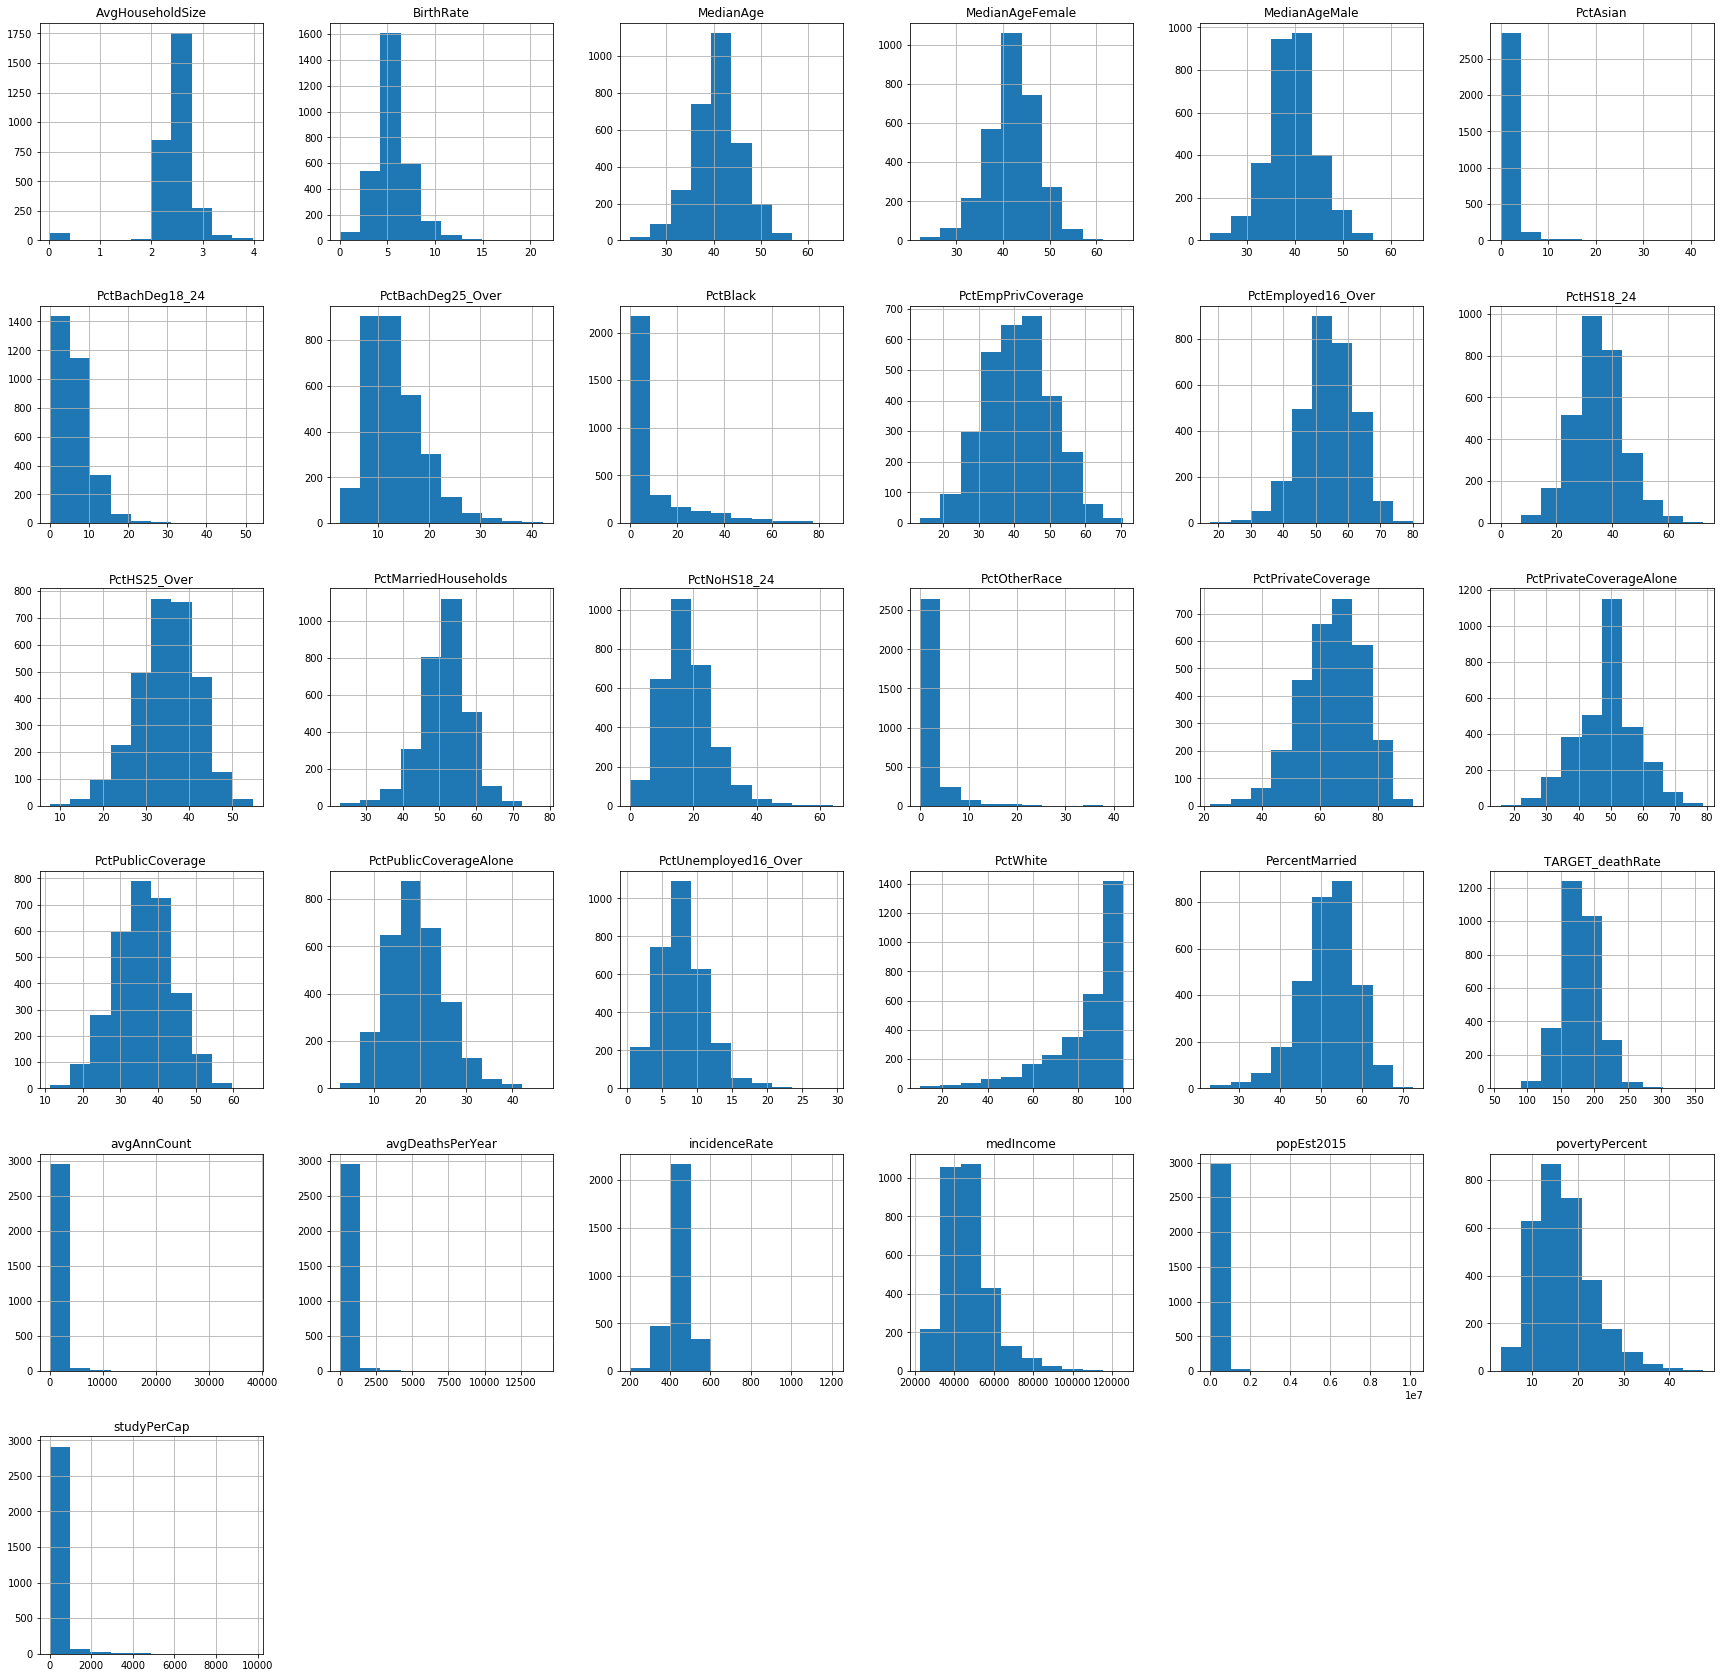

In [12]:
# Looking at the distribution of each column:
df.hist(figsize = (30, 30))

In [13]:
# It makes no sense to have an average household size smaller than 1 (that would imply that a few households have 
# zero people, which wouldn't make it a 'household'.) Because of this, we will not use the 'AvgHouseholdSize' 
# column in our analysis
df = df.loc[:, df.columns != 'AvgHouseholdSize']

In [14]:
# Since over 50% of the columns appear to follow a Gaussian distribution and many of the variables operate 
# on different scales, it makes sense to standardize the data before creating a model:
names = df.columns

scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns = names)
scaled_df.describe()

avgAnnCount  avgDeathsPerYear  TARGET_deathRate  incidenceRate  \
count  3.017000e+03      3.017000e+03      3.017000e+03   3.017000e+03   
mean  -1.535986e-16      7.674412e-17     -1.446271e-15   1.003663e-15   
std    1.000166e+00      1.000166e+00      1.000166e+00   1.000166e+00   
min   -4.230845e-01     -3.620372e-01     -4.289129e+00  -4.521223e+00   
25%   -3.738537e-01     -3.126557e-01     -6.255550e-01  -5.101630e-01   
50%   -3.077438e-01     -2.474720e-01     -1.976720e-02   9.881164e-02   
75%   -6.510653e-02     -7.759956e-02      5.968383e-01   5.979153e-01   
max    2.640346e+01      2.730545e+01      6.640293e+00   1.389669e+01   

          medIncome    popEst2015  povertyPercent   studyPerCap     MedianAge  \
count  3.017000e+03  3.017000e+03    3.017000e+03  3.017000e+03  3.017000e+03   
mean  -8.713981e-17  5.133448e-17   -3.759560e-16  2.384937e-16 -1.488148e-16   
std    1.000166e+00  1.000166e+00    1.000166e+00  1.000166e+00  1.000166e+00   
min   -2.026400e+00 -3.085470e-01   -2.132891e+00 -2.943456e-01 -3.564975e+00   
25%   -6.782348e-01 -2.756125e-01   -7.299192e-01 -2.943456e-01 -6.011973e-01   
50%   -1.538054e-01 -2.305351e-01   -1.687306e-01 -2.943456e-01  1.465246e-02   
75%    4.493713e-01 -1.036150e-01    5.483436e-01 -1.366397e-01  5.727663e-01   
max    6.520056e+00  3.048641e+01    4.757258e+00  1.805644e+01  4.710507e+00   

       MedianAgeMale  ...  PctPrivateCoverageAlone  PctEmpPrivCoverage  \
count   3.017000e+03  ...             3.017000e+03        3.017000e+03   
mean    2.202047e-16  ...             2.326427e-16        1.610320e-16   
std     1.000166e+00  ...             1.000166e+00        1.000166e+00   
min    -3.286263e+00  ...            -3.636744e+00       -2.939402e+00   
25%    -6.064815e-01  ...            -5.942888e-01       -7.113745e-01   
50%    -1.310135e-02  ...             1.863477e-04       -1.113715e-02   
75%     5.802788e-01  ...             5.938235e-01        6.784905e-01   
max     4.810505e+00  ...             3.380890e+00        3.129321e+00   

       PctPublicCoverage  PctPublicCoverageAlone      PctWhite      PctBlack  \
count       3.017000e+03            3.017000e+03  3.017000e+03  3.017000e+03   
mean        7.676252e-17            1.429270e-16 -6.624171e-16  4.982572e-17   
std         1.000166e+00            1.000166e+00  1.000166e+00  1.000166e+00   
min        -3.195203e+00           -2.721511e+00 -4.492874e+00 -6.250526e-01   
25%        -6.831581e-01           -7.266301e-01 -3.836197e-01 -5.824279e-01   
50%         1.817416e-02           -7.257088e-02  3.905180e-01 -4.711940e-01   
75%         6.812519e-01            6.305428e-01  7.197129e-01  9.120045e-02   
max         3.677853e+00            4.473141e+00  9.983522e-01  5.282818e+00   

           PctAsian  PctOtherRace  PctMarriedHouseholds     BirthRate  
count  3.017000e+03  3.017000e+03          3.017000e+03  3.017000e+03  
mean  -1.791371e-16  4.590664e-18          5.215877e-16 -9.722271e-17  
std    1.000166e+00  1.000166e+00          1.000166e+00  1.000166e+00  
min   -4.801405e-01 -5.624125e-01         -4.295117e+00 -2.842896e+00  
25%   -3.828244e-01 -4.787318e-01         -5.275665e-01 -5.617196e-01  
50%   -2.695968e-01 -3.279930e-01          6.510284e-02 -1.303896e-01  
75%   -1.333959e-02  5.507579e-02          6.302179e-01  4.298994e-01  
max    1.581616e+01  1.133476e+01          4.077458e+00  7.908400e+00  

[8 rows x 30 columns]

# Step 2: Building Initial Linear Regression Model

In [15]:
# Linear Regression Model with our data as-is:
y = df['TARGET_deathRate']
x = df.loc[:, df.columns != 'TARGET_deathRate']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       TARGET_deathRate   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              8737.
Date:                Mon, 18 May 2020   Prob (F-statistic):                        0.00
Time:                        17:46:57   Log-Likelihood:                         -13245.
No. Observations:                3017   AIC:                                  2.655e+04
Df Residuals:                    2988   BIC:                                  2.672e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
avgAnnCount                -0.0039      0.001     -4.978      0.000      -0.005      -0.002
avgDeathsPerYear            0.0200      0.004      5.018      0.000       0.012       0.028
incidenceRate               0.2006      0.007     27.401      0.000       0.186       0.215
medIncome                   0.0003   8.05e-05      3.315      0.001       0.000       0.000
popEst2015              -1.643e-05   5.58e-06     -2.943      0.003   -2.74e-05   -5.48e-06
povertyPercent              1.4424      0.131     11.000      0.000       1.185       1.699
studyPerCap             -4.389e-05      0.001     -0.064      0.949      -0.001       0.001
MedianAge                  -0.1367      1.106     -0.124      0.902      -2.306       2.032
MedianAgeMale              -0.3524      0.639     -0.551      0.581      -1.606       0.901
MedianAgeFemale             0.2306      0.548      0.421      0.674      -0.844       1.305
PercentMarried              1.0521      0.167      6.285      0.000       0.724       1.380
PctNoHS18_24               -0.0189      0.056     -0.335      0.738      -0.130       0.092
PctHS18_24                  0.2978      0.050      5.968      0.000       0.200       0.396
PctBachDeg18_24            -0.1468      0.111     -1.327      0.185      -0.364       0.070
PctHS25_Over                0.6046      0.097      6.237      0.000       0.414       0.795
PctBachDeg25_Over          -0.8341      0.154     -5.418      0.000      -1.136      -0.532
PctEmployed16_Over          0.0632      0.086      0.733      0.463      -0.106       0.232
PctUnemployed16_Over        0.6353      0.165      3.845      0.000       0.311       0.959
PctPrivateCoverage         -0.0100      0.134     -0.075      0.940      -0.272       0.252
PctPrivateCoverageAlone     0.0724      0.087      0.837      0.403      -0.097       0.242
PctEmpPrivCoverage          0.2397      0.106      2.262      0.024       0.032       0.447
PctPublicCoverage          -0.1181      0.233     -0.506      0.613      -0.576       0.339
PctPublicCoverageAlone      0.7363      0.285      2.585      0.010       0.178       1.295
PctWhite                    0.0119      0.057      0.209      0.834      -0.099       0.123
PctBlack                    0.0693      0.056      1.247      0.212      -0.040       0.178
PctAsian                    0.1527      0.191      0.799      0.424      -0.222       0.528
PctOtherRace               -0.5044      0.122     -4.145      0.000      -0.743      -0.266
PctMarriedHouseholds       -0.7764      0.151     -5.147      0.000      -1.072      -0.481
BirthRate                  -0.6664      0.196     -3.398      0.001      -1.051      -0.282
========================================

In [16]:
# Linear Regression model with standardized data:
y = scaled_df['TARGET_deathRate']
x = scaled_df.loc[:, df.columns != 'TARGET_deathRate']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       TARGET_deathRate   R-squared (uncentered):                   0.524
Model:                            OLS   Adj. R-squared (uncentered):              0.519
Method:                 Least Squares   F-statistic:                              113.3
Date:                Mon, 18 May 2020   Prob (F-statistic):                        0.00
Time:                        17:46:57   Log-Likelihood:                         -3161.8
No. Observations:                3017   AIC:                                      6382.
Df Residuals:                    2988   BIC:                                      6556.
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
avgAnnCount                -0.1632      0.040     -4.126      0.000      -0.241      -0.086
avgDeathsPerYear            0.3218      0.071      4.516      0.000       0.182       0.462
incidenceRate               0.3761      0.014     26.415      0.000       0.348       0.404
medIncome                   0.0502      0.035      1.444      0.149      -0.018       0.118
popEst2015                 -0.1850      0.065     -2.837      0.005      -0.313      -0.057
povertyPercent              0.0873      0.037      2.340      0.019       0.014       0.160
studyPerCap                 0.0009      0.013      0.071      0.943      -0.024       0.026
MedianAge                   0.0565      0.203      0.278      0.781      -0.342       0.455
MedianAgeMale              -0.1174      0.118     -0.994      0.320      -0.349       0.114
MedianAgeFemale            -0.0555      0.103     -0.538      0.590      -0.257       0.147
PercentMarried              0.3192      0.041      7.746      0.000       0.238       0.400
PctNoHS18_24               -0.0412      0.016     -2.497      0.013      -0.074      -0.009
PctHS18_24                  0.0738      0.016      4.572      0.000       0.042       0.105
PctBachDeg18_24            -0.0135      0.018     -0.759      0.448      -0.048       0.021
PctHS25_Over                0.1062      0.025      4.335      0.000       0.058       0.154
PctBachDeg25_Over          -0.2271      0.030     -7.569      0.000      -0.286      -0.168
PctEmployed16_Over         -0.1561      0.029     -5.303      0.000      -0.214      -0.098
PctUnemployed16_Over        0.0187      0.021      0.900      0.368      -0.022       0.060
PctPrivateCoverage         -0.1903      0.053     -3.587      0.000      -0.294      -0.086
PctPrivateCoverageAlone     0.0140      0.028      0.508      0.611      -0.040       0.068
PctEmpPrivCoverage          0.1248      0.036      3.513      0.000       0.055       0.195
PctPublicCoverage          -0.0705      0.065     -1.088      0.277      -0.197       0.057
PctPublicCoverageAlone      0.0730      0.062      1.175      0.240      -0.049       0.195
PctWhite                   -0.0853      0.034     -2.518      0.012      -0.152      -0.019
PctBlack                   -0.0319      0.029     -1.091      0.275      -0.089       0.025
PctAsian                   -0.0062      0.018     -0.346      0.729      -0.041       0.029
PctOtherRace               -0.1116      0.016     -7.075      0.000      -0.143      -0.081
PctMarriedHouseholds       -0.3051      0.037     -8.294      0.000      -0.377      -0.233
BirthRate                  -0.0634      0.014     -4.587      0.000      -0.091      -0.036
========================================

**Note: Both the $R^2$ value and the F-statistic are significantly higher for our model using the original data rather than the standardized data, so we will use the original data moving forward.**

# Step 3: Improving Model

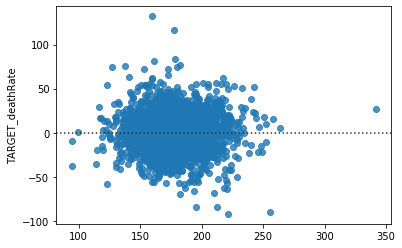

In [17]:
# Looking at the residual plot:
y = df['TARGET_deathRate']
x = df.loc[:, df.columns != 'TARGET_deathRate']
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
sns.residplot(predictions, y)
plt.show() 

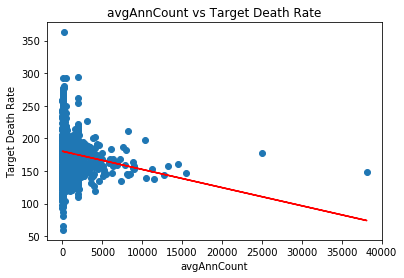

R Squared: 0.02040529275565861


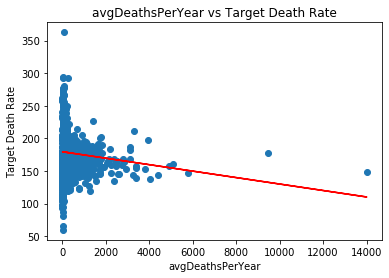

R Squared: 0.008176842750846514


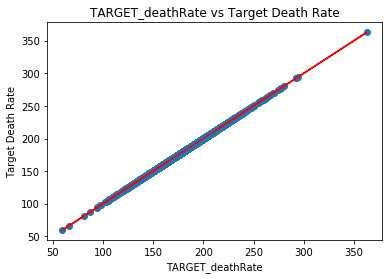

R Squared: 1.0


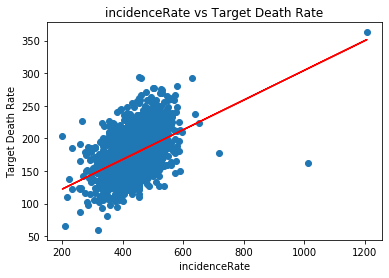

R Squared: 0.20103085925421316


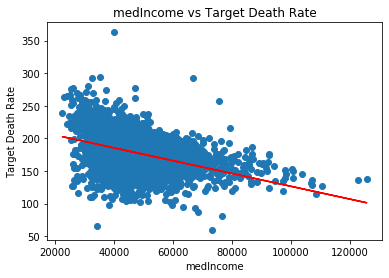

R Squared: 0.1830324311885032


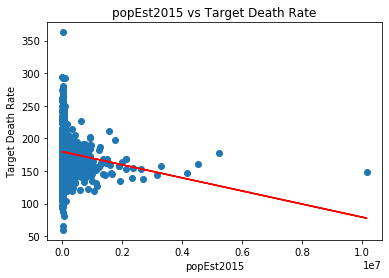

R Squared: 0.014260643985227306


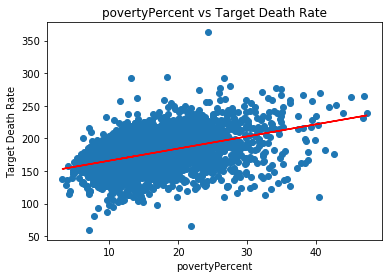

R Squared: 0.18430686427345921


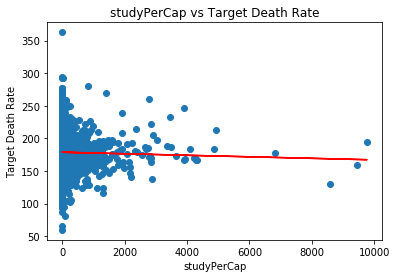

R Squared: 0.0005054251655455255


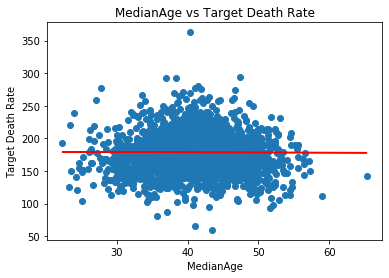

R Squared: 1.8387407744513418e-05


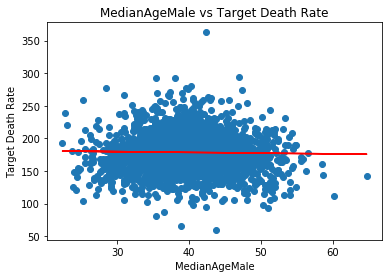

R Squared: 0.00045861577467087855


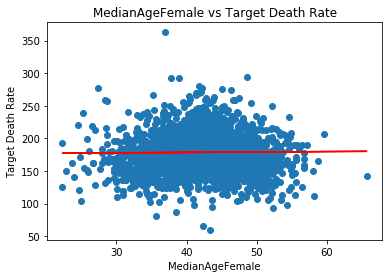

R Squared: 0.0001620726108788606


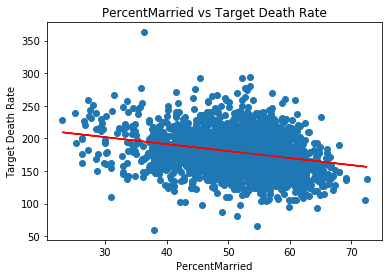

R Squared: 0.071208437140443


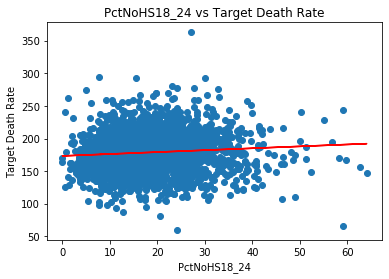

R Squared: 0.007300696565935461


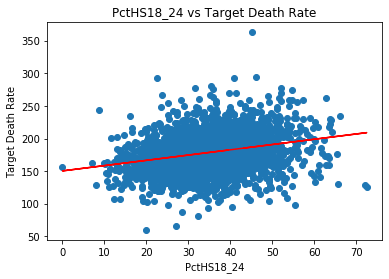

R Squared: 0.07002386050665621


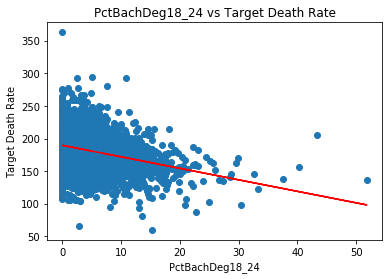

R Squared: 0.08325127190755477


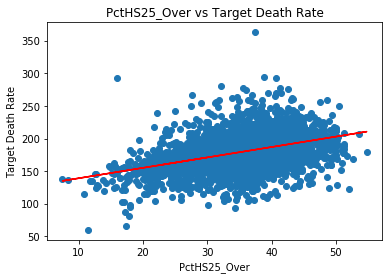

R Squared: 0.16415716039343908


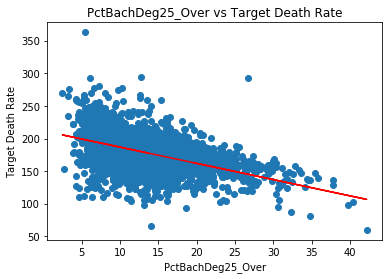

R Squared: 0.23542220688259685


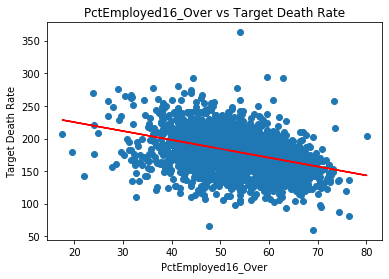

R Squared: 0.15837276524696264


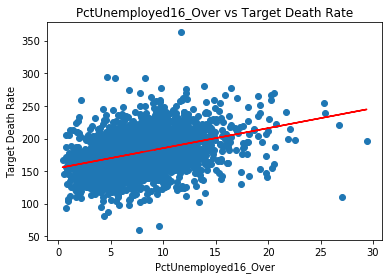

R Squared: 0.14412510198542905


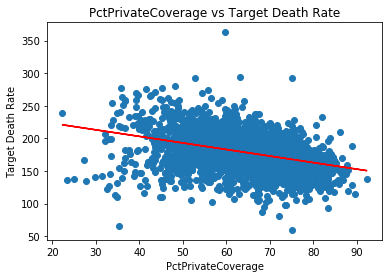

R Squared: 0.14806509289816827


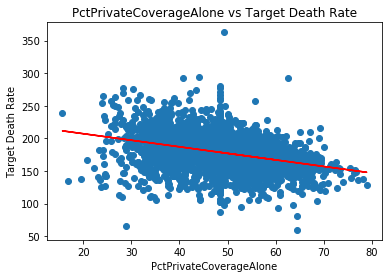

R Squared: 0.10660486950970294


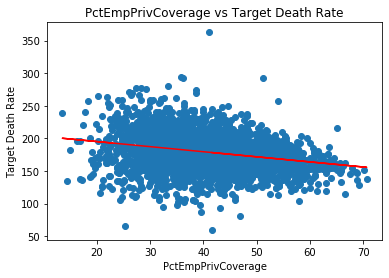

R Squared: 0.07008081943360545


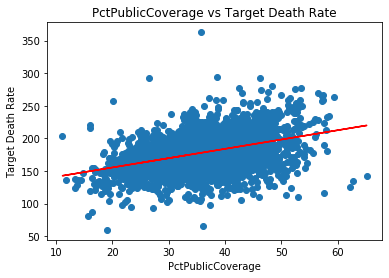

R Squared: 0.16384642158240215


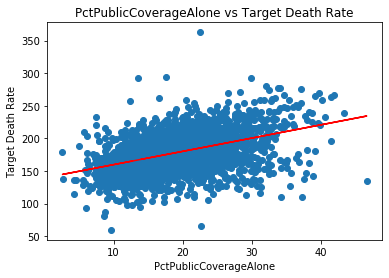

R Squared: 0.20149992079023105


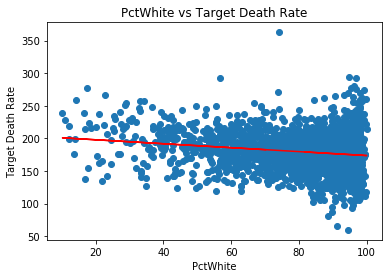

R Squared: 0.031843326973792774


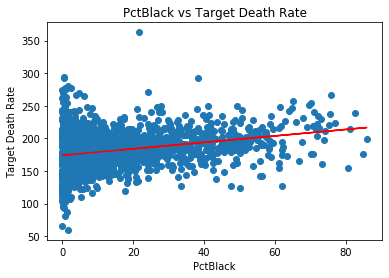

R Squared: 0.06737862088073332


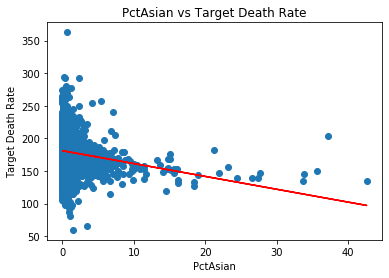

R Squared: 0.03447874275606544


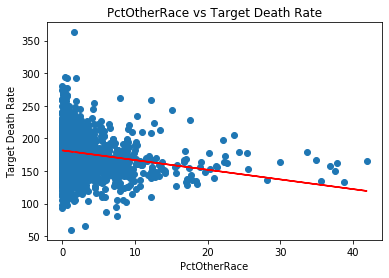

R Squared: 0.035468405166209416


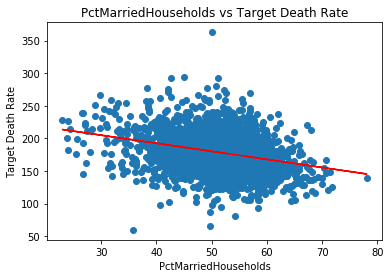

R Squared: 0.08618726237444929


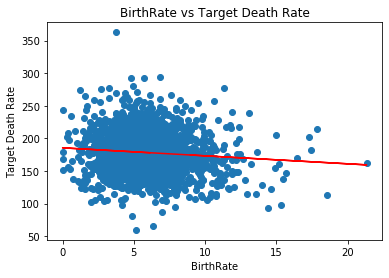

R Squared: 0.007673405521148813


In [18]:
# The residual plot is not great, so let's see if we can reduce the number of features to achieve a better model:
for i in df.columns:
    x = np.array(df[i])
    y = np.array(df['TARGET_deathRate']) 
    plt.scatter(x, y) # create scatter plot
    plt.title(i + " vs Target Death Rate")
    plt.xlabel(i)
    plt.ylabel("Target Death Rate")

    denominator = x.dot(x) - x.mean() * x.sum()
    m = (x.dot(y) - y.mean() * x.sum()) / denominator
    b = (y.mean() * x.dot(x) - x.mean() * x.dot(y)) / denominator
    y_pred = m*x + b
    plt.plot(x, y_pred, 'r') #including r-value
    
    res = y - y_pred
    tot = y - y.mean()
    
    R_sqr = 1 - res.dot(res) / tot.dot(tot)
    
    plt.show()
    print("R Squared: " + str(R_sqr))

In [19]:
# Looking at the scatterplots of all our predicting variables against our dependent variable, we see that the 
# predictors 'studyPerCap', 'MedianAge', 'MedianAgeMale', and 'MedianAgeFemale' have by far the lowest R-squared
# values (all less than 0.001). Let's remove those and see how our model performs:

lowCorr = ['studyPerCap', 'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'BirthRate', \
           'PctOtherRace', 'PctAsian', 'PctNoHS18_24', 'avgAnnCount', 'avgDeathsPerYear', 'popEst2015',\
          'PercentMarried', 'PctHS18_24', 'PctBachDeg18_24', 'PctEmpPrivCoverage', 'PctWhite', 'PctBlack']
for i in lowCorr:
    df = df.loc[:, df.columns != i]

y = df['TARGET_deathRate']
x = df.loc[:, df.columns != 'TARGET_deathRate']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       TARGET_deathRate   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          2.005e+04
Date:                Mon, 18 May 2020   Prob (F-statistic):                        0.00
Time:                        17:47:01   Log-Likelihood:                         -13331.
No. Observations:                3017   AIC:                                  2.669e+04
Df Residuals:                    3005   BIC:                                  2.676e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
incidenceRate               0.2124      0.007     29.089      0.000       0.198       0.227
medIncome                   0.0002   6.79e-05      3.049      0.002    7.39e-05       0.000
povertyPercent              1.2010      0.114     10.556      0.000       0.978       1.424
PctHS25_Over                0.9271      0.087     10.672      0.000       0.757       1.097
PctBachDeg25_Over          -0.7254      0.144     -5.044      0.000      -1.007      -0.443
PctEmployed16_Over          0.1608      0.073      2.216      0.027       0.019       0.303
PctUnemployed16_Over        0.7890      0.161      4.900      0.000       0.473       1.105
PctPrivateCoverage          0.0119      0.107      0.111      0.912      -0.198       0.222
PctPrivateCoverageAlone     0.1043      0.087      1.198      0.231      -0.066       0.275
PctPublicCoverage          -0.0237      0.133     -0.178      0.859      -0.284       0.237
PctPublicCoverageAlone      0.5998      0.223      2.692      0.007       0.163       1.037
PctMarriedHouseholds       -0.0132      0.067     -0.197      0.844      -0.144       0.118
==============================================================================
Omnibus:                      190.661   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              797.826
Skew:                           0.132   Prob(JB):                    5.68e-174
Kurtosis:                       5.505   Cond. No.                     3.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

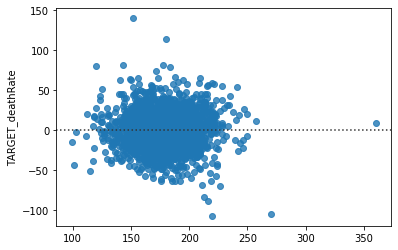

In [20]:
# Plotting new residual plot:
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
sns.residplot(predictions, y)

Compared to our original model, our newest model has an equivalent R-squared value, but a much better F-statistic
(20,050 compared to 8,737) and also a lower condition number (35,600 compared to 1,320,000)